In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader,random_split
from torchvision import transforms, datasets, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

100%|██████████| 2/2 [00:09<00:00,  4.61s/it]


Epoch 29/100: training accuracy: 0.486586493987049, valid accuracy: 0.2809917355371901,train loss: 1.8025611994114328,valid loss:2.3270930672480055


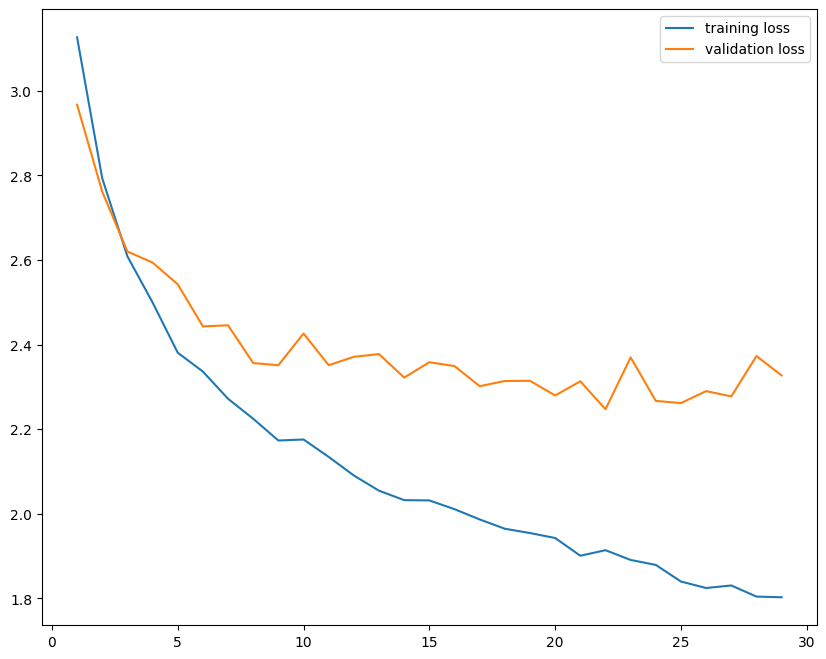

In [2]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

for param in bird_model.parameters():
    param.requires_grad = False

    
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)    

mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()
    
    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()    

In [3]:
bird_model = models.mobilenet_v2()
for i in range(0,19):
    print(bird_model.features[i])


Conv2dNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0):

In [ ]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

for param in bird_model.parameters():
    param.requires_grad = False

for i in range(0,4):
    for param in bird_model.features[i].parameters():
        param.requires_grad = True

num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)    

mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()

In [24]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

for param in bird_model.parameters():
    param.requires_grad = True

for i in range(0,6):
    for param in bird_model.features[i].parameters():
        param.requires_grad = False

num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)    

mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()

 24%|██▎       | 4/17 [00:17<00:55,  4.25s/it]


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 54, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torch\utils\data\_utils\collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torch\utils\data\_utils\collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torch\utils\data\_utils\collate.py", line 160, in collate_tensor_fn
    storage = elem._typed_storage()._new_shared(numel, device=elem.device)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torch\storage.py", line 866, in _new_shared
    untyped_storage = torch.UntypedStorage._new_shared(size * self._element_size(), device=device)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torch\storage.py", line 260, in _new_shared
    return cls._new_using_filename_cpu(size)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Couldn't open shared file mapping: <0000022CA1767DE2>, error code: <1455>


100%|██████████| 2/2 [00:07<00:00,  3.69s/it]

Epoch 16/100: training accuracy: 0.42923219241443106, valid accuracy: 0.2809917355371901,train loss: 1.997822347997406,valid loss:2.489525948674226


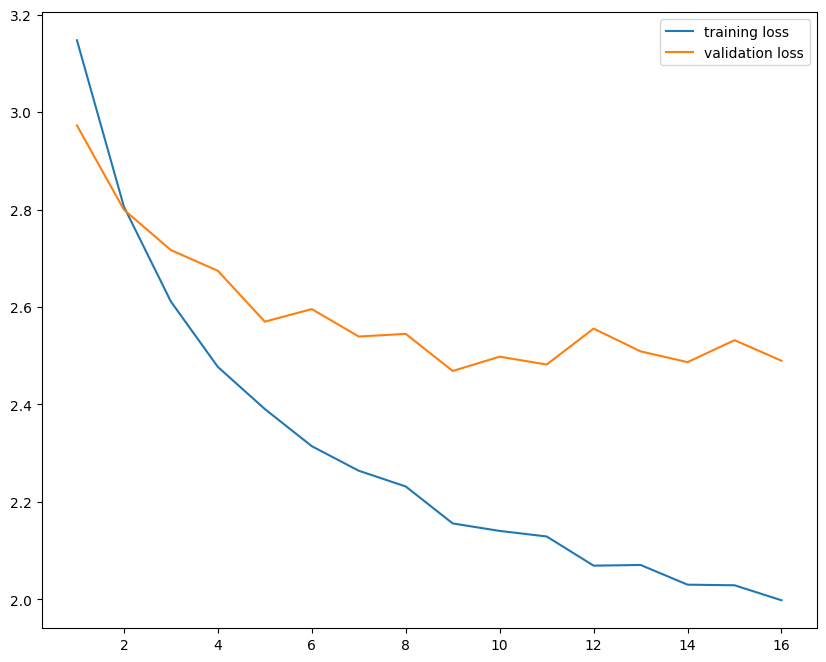

In [4]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 20:
        for param in child.parameters():
            param.requires_grad = False
    
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()

100%|██████████| 2/2 [00:09<00:00,  4.95s/it]

Epoch 18/100: training accuracy: 0.43293246993524515, valid accuracy: 0.2975206611570248,train loss: 1.9646269871502646,valid loss:2.4820093537165113


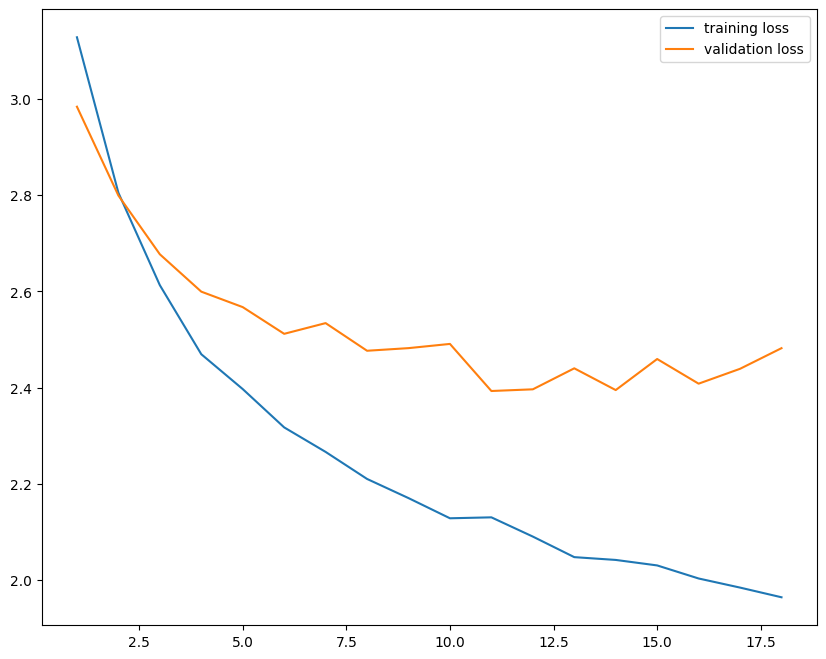

In [5]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 30:
        for param in child.parameters():
            param.requires_grad = False
    
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()

100%|██████████| 2/2 [00:06<00:00,  3.42s/it]

Epoch 30/100: training accuracy: 0.48103607770582796, valid accuracy: 0.2975206611570248,train loss: 1.7770893517519786,valid loss:2.336549079122622


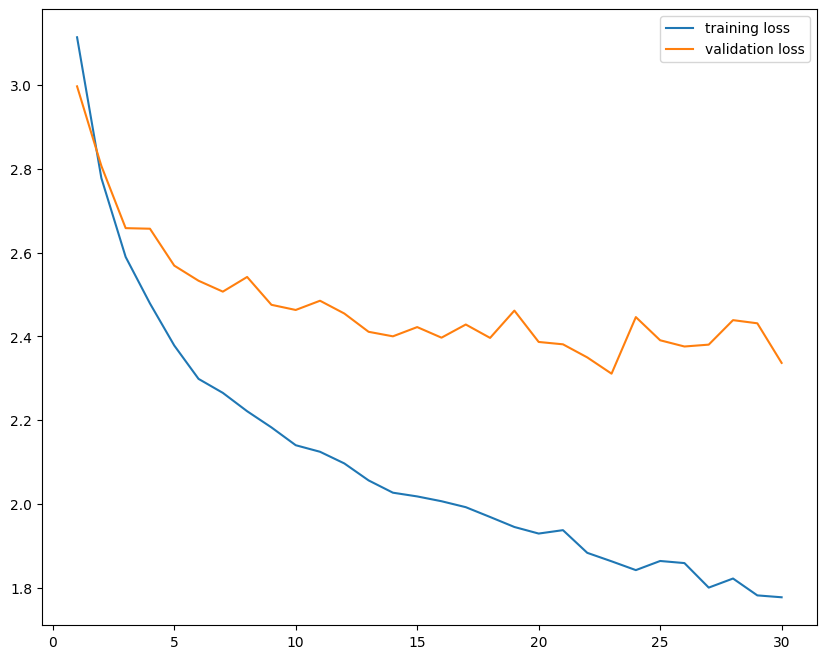

In [6]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 40:
        for param in child.parameters():
            param.requires_grad = False
    
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()

100%|██████████| 2/2 [00:06<00:00,  3.38s/it]

Epoch 25/100: training accuracy: 0.4495837187789084, valid accuracy: 0.36363636363636365,train loss: 1.8673903892483565,valid loss:2.5222039794133715


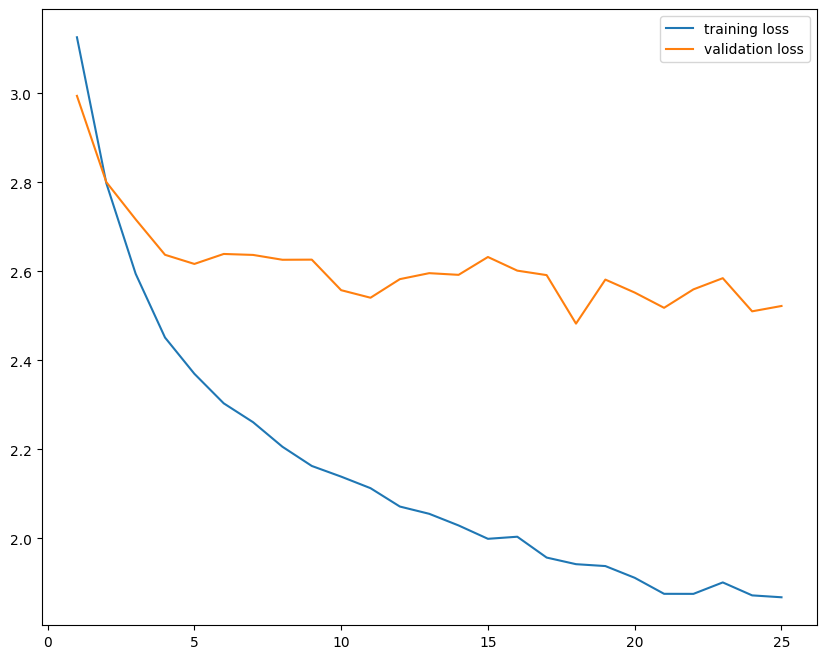

In [7]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 50:
        for param in child.parameters():
            param.requires_grad = False
    
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()

100%|██████████| 2/2 [00:07<00:00,  3.82s/it]

Epoch 25/100: training accuracy: 0.4551341350601295, valid accuracy: 0.32231404958677684,train loss: 1.859689077881064,valid loss:2.61399845643477


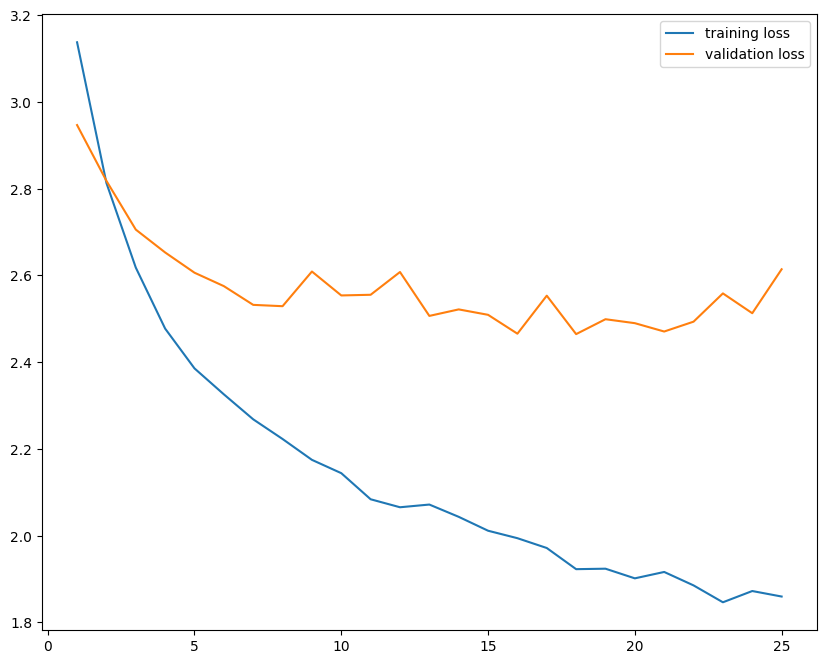

In [8]:
bird_model = models.mobilenet_v2()
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)
bird_model.load_state_dict(torch.load('MobileNetV2_dog_model.pt'))

# for param in bird_model.parameters():
#     param.requires_grad = False
ct = 0
for child in bird_model.children():
    ct += 1
    if ct <= 60:
        for param in child.parameters():
            param.requires_grad = False
    
num_ftrs = bird_model.classifier[1].in_features
bird_model.classifier[1]=nn.Linear(num_ftrs, 25,bias=True)

for param in bird_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bird_model = bird_model.to(device)


mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/HW2_Dataset/dataset_new'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train ))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=1e-3)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(bird_model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(bird_model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    if early_stopper.early_stop(valid_loss):
        print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
        break

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()